<a href="https://colab.research.google.com/github/carlm451/LSTM_Character_Language_Model/blob/main/Notebook1_RNN_vs_LSTM_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance comparison between basic RNN and GPU enabled LSTM

This notebook compares the performance of a minimal character level RNN, with a more developed LSTM model + a number of enhancements. 

## Training Data: Homer's Illiad 

![picture](https://upload.wikimedia.org/wikipedia/commons/0/0d/Iliad_VIII_245-253_in_cod_F205%2C_Milan%2C_Biblioteca_Ambrosiana%2C_late_5c_or_early_6c.jpg)

As an example of interesting text data to train on, I decided to experiment with models trained on the text of [The Illiad](https://en.wikipedia.org/wiki/Iliad), the epic ancient poem by Homer. 

This text seemed to be good starting point because it is somehwere between poetry and a novel. There are lot of short sentences, with many repeated phrases, heroic epitaphs. There are also many proper names of gods, goddesses, warriors, and places, such as Jove, Achilles, Hector, Patrocles, Troy, Greece, etc... 

I am using a version of the text taken from the open source Project Gutenberg. 
The original files can be found [here](https://www.gutenberg.org/ebooks/6130)

In order to focus training on only the translated body of text, I removed the introduction/preface and the appendix. 

Below I will import the cleaned text version from my GitHub repo. 

Later, I also import the lstm code as module to the local Colab drive. 

Let's see how well the recurrent sequence models do at mimicing the text. 

In [1]:
#importing the cleaned text data 
import requests

text_url = 'https://raw.githubusercontent.com/carlm451/LSTM_Character_Language_Model/main/books/illiad_clean.txt'

r_text = requests.get(text_url)

data=r_text.text

print('Opening lines of the Illiad:\n\n')

print(data[:1000]+'...')

Opening lines of the Illiad:


﻿THE ILIAD.

BOOK I.

ARGUMENT.[40]

THE CONTENTION OF ACHILLES AND AGAMEMNON.


In the war of Troy, the Greeks having sacked some of the neighbouring
towns, and taken from thence two beautiful captives, Chryseïs and
Briseïs, allotted the first to Agamemnon, and the last to Achilles.
Chryses, the father of Chryseïs, and priest of Apollo, comes to the
Grecian camp to ransom her; with which the action of the poem opens, in
the tenth year of the siege. The priest being refused, and insolently
dismissed by Agamemnon, entreats for vengeance from his god; who
inflicts a pestilence on the Greeks. Achilles calls a council, and
encourages Chalcas to declare the cause of it; who attributes it to the
refusal of Chryseïs. The king, being obliged to send back his captive,
enters into a furious contest with Achilles, which Nestor pacifies;
however, as he had the absolute command of the army, he seizes on
Briseïs in revenge. Achilles in discontent withdraws himself and 

In [2]:
# create global mapping for characters to token indices
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

lines = len(data.split('\n'))

print(f"The text has {lines} lines")

data has 896102 characters, 95 unique.
The text has 21253 lines


## vanilla RNN min-char-rnn.py by Andrej Karpathy

In [3]:
import numpy as np

# hyperparameters
hidden_size = 128 # size of hidden layer of neurons
seq_length = 100 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

n_rnn_params = Wxh.size + Whh.size + Why.size + bh.size + by.size

print(f'Training RNN size {hidden_size} on sequences of length {seq_length}')

print(f'Minimum RNN model has {n_rnn_params} trainable parameters')

print(f'There are {len(data)//seq_length} sequences of length {seq_length} in one training epoch')

Training RNN size 128 on sequences of length 100
Minimum RNN model has 40927 trainable parameters
There are 8961 sequences of length 100 in one training epoch


### RNN implementation

In [4]:
# functions for RNN implementation and sampling function

def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """
  sample a sequence of integers from the model
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

### RNN training loop

In [5]:
#Main traning loop
total_steps = 8000
sample_freq = 250

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while n<total_steps:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0:
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % sample_freq == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % sample_freq == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress

  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter

#print final loss, for comparison to LSTM 
print(f'\nFinal RNN training loss: {loss}\n')

  # ~ 2 minutes

----
 l‘cg7’'V5ä(L
H/pEa“ei02’7X,?y)KÆægQöb(:e'kfq7‘O9(78P0ëvm
RgUo’zö! PXB?vèF‘vVŒ9kz(4ux9söPAc.GvwSUimäïDjMOTsoïU?eöP’)6PBéèr-, aDeéK
.’‘vG-VV﻿a 
----
iter 0, loss: 455.387685
----
 csTh  de eheea n s e n ao ide
Oh ooe:ïlsotwuds hse —paorhu twaoric nee r i 
----
iter 250, loss: 438.421079
----
  ts f gid ittalogfl oeufntotid spet lob inpir otwsd surd
pe atd sl.
6zesVe’ fotak otospe, istnpendidd pvumwcrlasgssypt
Onm tih teahi avul sm drwd,
“wioun llrtons ofnm i tis

Owoecmarlty at uss wi 
----
iter 500, loss: 406.503712
----
 is mhe wamd wor thouvecple dins tondscirr weydinrsr aue.
TEasf sur wnoda,.
Whures are;
tSltdain ngis,aFs sardh lry, Ssiriwialeled; st ionc,
Can bter, Cures thh ond hepfcoanagbl ,erse The shonm.”bj 
----
iter 750, loss: 374.465418
----
 
Ay fomaar ch wir.;
The aletrat tren thetsre the
jein lthils,
nady,
Thik! soad ,ind vheag can lrend thermukdats pane the difaslae, boosguns,
The sreand erey mocelrmistrreds
Os is piwris ther, a 
----
iter 1000, loss: 346.305914
---

In [8]:
#sample longer text from final RNN model
from textwrap import wrap

sample_ix = sample(np.zeros((hidden_size,1)), np.random.randint(vocab_size), 1000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)

txt_wrap = wrap(txt,80)
txt_wrap = [line.center(100) for line in txt_wrap]
txt = '\n'.join(txt_wrap)  # wrap text to make readable

print('----\n %s \n----' % (txt,))

----
            e nols or cond, ve whet briastly un pere, ly’ vechend faid)  B plact, pow with           
             sonand’d of sir, me fraid.  His or soutr, ert, anwring sorbrost, Impry Oy              
           fatilvedr ald swisecubongn’d paid fles sa bechiro Jad vae hisp ow my gchirmof            
            hin reize on th tue,  Abrone mew frey whe imMelip fre?  Hor,  PÆoventt, agr             
          beain the!  Yot a] Sod to ferdime with seark Tresteces Hath! tco sher Theife lay          
          shaamfsce lod ward, eana grer Mackyl shald, fow Iæparing ow he dettrings meach.           
              Fudone the ifhe move!  ”nd with Theru swosop preit, on to recefine doles              
          defesase, hiin fered c to the fered!  Wall whees mertlest mor thous fathily fert          
           and.  At come wire ufon:  Gwet on hor,  Oullond,  And my for stom head heanss            
            orlusancme sthas ysiain, yfir, buers thin alr ar,  Whainstes soom;  Jact 

## LSTM module --- JAX + Adam optimizations + embedding layer 

In [10]:
import requests

url = 'https://raw.githubusercontent.com/carlm451/LSTM_Character_Language_Model/main/jax_char_lstm.py?token=GHSAT0AAAAAACCB2Q2HCKE6IPMH4BBMK3KYZCRGQMA'
r = requests.get(url)

with open('jax_char_lstm.py','w') as file:
     file.write(r.text)

### LSTM implementation

In [11]:
import jax.numpy as jnp  # jax version of numpy 
from jax import random

from textwrap import wrap

#custom module which implements a deep LSTM character language model 
import jax_char_lstm as lstm

### LSTM Training loop

To compare to the RNN performance, will first run an equivalent LSTM model with 
same size = 128, and train on the same seq length 100 characters. 

The LSTM network here processes batches in parallel, instead of just a single sequence at a time. Here I will start with a modest batch size = 16, and train for only 500 steps. 16*500 = 8000 , this model will about the same amount of data as the above RNN model. 

In [12]:

key=random.PRNGKey(33)

hidden_sizes = [128]
seq_length = 100

mini_batch_size = 16

total_steps = 505

#take 20% for validation data 
n_split = round(len(data)*0.8)
train_data = data[:n_split]
val_data = data[n_split:]

history_1,out_params_1,out_hidden_1 = lstm.train_character_lstm(
                                  seq_length=seq_length,
                                  hidden_sizes=hidden_sizes,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=total_steps,
                                  steps_sample_freq=250,
                                  key=key,
                                  training_data=train_data,
                                  validation_data=val_data,
                                  beta1=0.9,
                                  beta2=0.999)

# ~ 2 min

-1 Exe (128, 95)
Layer -1: 12160 parameters
0 Wxc (128, 128)
0 Wxu (128, 128)
0 Wxf (128, 128)
0 Wxo (128, 128)
0 bc (128, 1)
0 bu (128, 1)
0 bf (128, 1)
0 bo (128, 1)
0 Whc (128, 128)
0 Whu (128, 128)
0 Whf (128, 128)
0 Who (128, 128)
Layer 0: 131584 parameters
1 Why (95, 128)
1 by (95, 1)
Layer 1: 12255 parameters
LSTM Model has 2 layers with 155999 parameters
Adam Step Tracing...
95
(128, 95),(95, 16)!!!!!!!!!!!
----
               5æoè-/kv'“SPa2Gan2  O“ilM]äiwNiæüj7:D!r”66bhbVAR﻿d;20D79mXi;X1æEIä8PèwX-              
            Œèrkz8wwWS2öbn;ïp9pä9VLë)ZœIeYfïcAV1x2GB0L;æïk‘jdC7—ucLFæVJKIW2lPuDDC-münegx            
                        YO0yYsA“ewMœrSAjDæJK4éÆ303R)'SAy?uëLSLp6éO﻿ëCCc]vjnü                         
----
Step n: 0	 Epoch: 0
Train Current: 455.3872	Train Smoothed: 455.3877
Val loss tracing...
(128, 95),(95, 16)!!!!!!!!!!!
Val Current: 453.7483
----
             üill swatie’d’d tharor pweresher tith the pamur shicese, sthust hiss the wis            
             fhas 

In [14]:
sample_size = 1000

key,subkey=random.split(key) #use key to get next key, subkey for random number

h_zeros_start = {l:jnp.zeros_like(out_hidden_1[0][l]) for l in range(1)}
c_zeros_start = {l:jnp.zeros_like(out_hidden_1[1][l]) for l in range(1)}

sample_ix = lstm.sample(char_to_ix['T'],sample_size,subkey,h_zeros_start,c_zeros_start,out_params_1[0],temperature=1.0)

txt = ''.join(ix_to_char[ix] for ix in sample_ix)
txt_wrap = wrap(txt,80)
txt_wrap = [line.center(100) for line in txt_wrap]
txt = '\n'.join(txt_wrap)  # wrap text to make readable

print('----\n %s \n----' % (txt,))

----
             T10]    “antars owis him whom and.  Spine.      Pro’k Gread;  Be cause, one.            
           From Murctumun cords woull’d with nields slaids)  Whemas dothus with vingus of           
           when, batcrenio’d his rangless conmodes Anore.  His imchood,  In the gregrath            
            the shine.  Whily the yian plains.      A PUMEPELlw Ammreacinatures to mand.            
           “On arms Illing tho mhall bongaty to the satiand their banst. been Ackind the            
           con! the behing groads to nus to Phistichs shield dussun of mæsitade whises at           
          thand:  Fulr the blatten undind.  The sine fand steed.  Theuph ata studus boydes          
          now tarev’d, an nigny aud back orved Meingious ciwhone’d in civingo nimy swells,          
           Ghen nevedrilk) in lefty Gremlied,  With ofn Aplights  Atrowas dorrs Atreblen.           
          The breakatht:          The pringrelaltion val hiers.  By the Pelaster, Eur

In [15]:
hidden_sizes = [128]
seq_length = 100

mini_batch_size = 16

total_steps = 5005

#take 20% for validation data 
n_split = round(len(data)*0.8)
train_data = data[:n_split]
val_data = data[n_split:]

history_2,out_params_2,out_hidden_2 = lstm.train_character_lstm(
                                  seq_length=seq_length,
                                  hidden_sizes=hidden_sizes,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=total_steps,
                                  steps_sample_freq=250,
                                  key=key,
                                  training_data=train_data,
                                  validation_data=val_data,
                                  beta1=0.9,
                                  beta2=0.999)

# ~ 2 min

-1 Exe (128, 95)
Layer -1: 12160 parameters
0 Wxc (128, 128)
0 Wxu (128, 128)
0 Wxf (128, 128)
0 Wxo (128, 128)
0 bc (128, 1)
0 bu (128, 1)
0 bf (128, 1)
0 bo (128, 1)
0 Whc (128, 128)
0 Whu (128, 128)
0 Whf (128, 128)
0 Who (128, 128)
Layer 0: 131584 parameters
1 Why (95, 128)
1 by (95, 1)
Layer 1: 12255 parameters
LSTM Model has 2 layers with 155999 parameters
----
           5ï-9cPy Qx﻿5qAMaBUq1‘CPds [e;i8 ëE”Yz7ä Ws:‘N(w/X‘AU]iW 3zMkA4b)v6rC:At;]ZW“k5oo          
            6x/F2PcbfM8’6öhAu,’!!kKc vR ”?n)?;1ZsMFsœd YœœSV?:ü yW“ œsöL?E‘vVd[’”SvlQ8Zm            
                            æUM8y/,EQTJny,9 gFovlN3pïI1H2916ëŒ)d'L ( AH                              
----
Step n: 0	 Epoch: 0
Train Current: 455.3878	Train Smoothed: 455.3877
Val Current: 453.7826
----
             Hdise,  Andring to staghterd the camlen hons, the sprill he blojagcood thus             
           thrus the lmunse ader;  Wheed,  Le,  Tont,  Hed;  And slise shing stier,  Ace            
                     

In [16]:
import matplotlib.pyplot as plt

import numpy as np

def plot_training_history(history,mini_batch_size,seq_length,training_length,plot_smooth=False,plot_val=True):

    step_list,smooth_losses,train_losses,val_losses = history

    fig,ax = plt.subplots(figsize=(10,6))

    t_list = np.array(step_list)

    t_list = t_list * mini_batch_size * seq_length / training_length

    train_log_loss = np.array(train_losses)

    if plot_smooth:
       smooth_log_loss = np.array(smooth_losses)
       ax.plot(t_list,smooth_log_loss,'bo-')

    ax.plot(t_list,train_log_loss,'go-')

    if len(val_losses)==len(step_list) and plot_val:
       val_log_loss = np.array(val_losses)

       ax.plot(t_list,val_log_loss,'ro-')

    ax.set_ylabel('$L$')
    ax.set_xlabel('Epochs')

    plt.show()

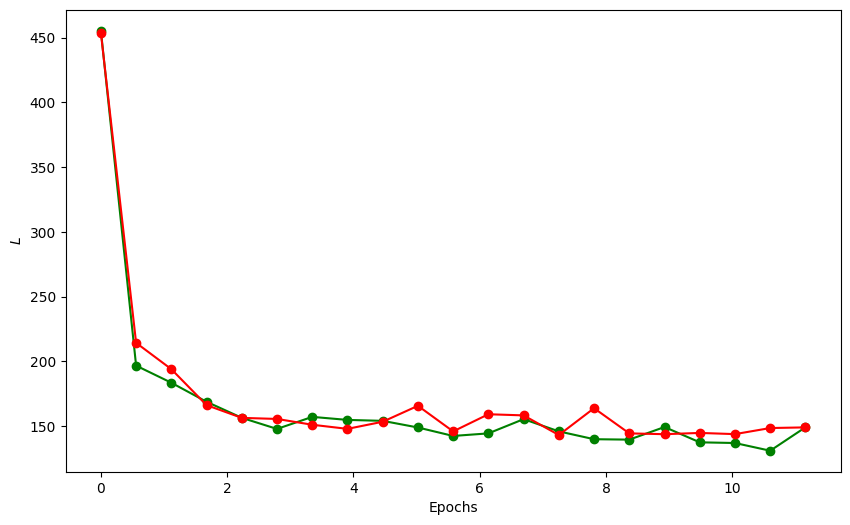

In [17]:
plot_training_history(history_2,
                      mini_batch_size,
                      seq_length,
                      len(train_data))

In [18]:
hidden_sizes = [256,256]
seq_length = 100

mini_batch_size = 64

total_steps = 5005

#take 20% for validation data 
n_split = round(len(data)*0.8)
train_data = data[:n_split]
val_data = data[n_split:]

history_3,out_params_3,out_hidden_3 = lstm.train_character_lstm(
                                  seq_length=seq_length,
                                  hidden_sizes=hidden_sizes,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=total_steps,
                                  steps_sample_freq=250,
                                  key=key,
                                  training_data=train_data,
                                  validation_data=val_data,
                                  beta1=0.9,
                                  beta2=0.999)

# ~ 10-15 min

-1 Exe (256, 95)
Layer -1: 24320 parameters
0 Wxc (256, 256)
0 Wxu (256, 256)
0 Wxf (256, 256)
0 Wxo (256, 256)
0 bc (256, 1)
0 bu (256, 1)
0 bf (256, 1)
0 bo (256, 1)
0 Whc (256, 256)
0 Whu (256, 256)
0 Whf (256, 256)
0 Who (256, 256)
Layer 0: 525312 parameters
1 Wxc (256, 256)
1 Wxu (256, 256)
1 Wxf (256, 256)
1 Wxo (256, 256)
1 bc (256, 1)
1 bu (256, 1)
1 bf (256, 1)
1 bo (256, 1)
1 Whc (256, 256)
1 Whu (256, 256)
1 Whf (256, 256)
1 Who (256, 256)
Layer 1: 525312 parameters
2 Why (95, 256)
2 by (95, 1)
Layer 2: 24415 parameters
LSTM Model has 3 layers with 1099359 parameters
Adam Step Tracing...
95
(256, 95),(95, 64)!!!!!!!!!!!
----
            5Wéne)ymJë]PRSUDl‘HZl6)bXZDez/A16Sy6UuVoMQSükï;9MOP0N03[tn8ä695gM[ë‘(d7[y“bltm           
                             n:YUE /Y .4kP﻿bdT—Gy(1L1öecuL[WYu()!s—xyx                              
          LeÆTxIy9jBDï11IvCxIkŒöëæü“gPjFK1-jk“,0A8AhéüT'UaD5Æp.UKqwcKQ9s8POoöM6r‘Ejæbfnï02           
----
Step n: 0	 Epoch: 0
Train Current: 455.3872	Tr

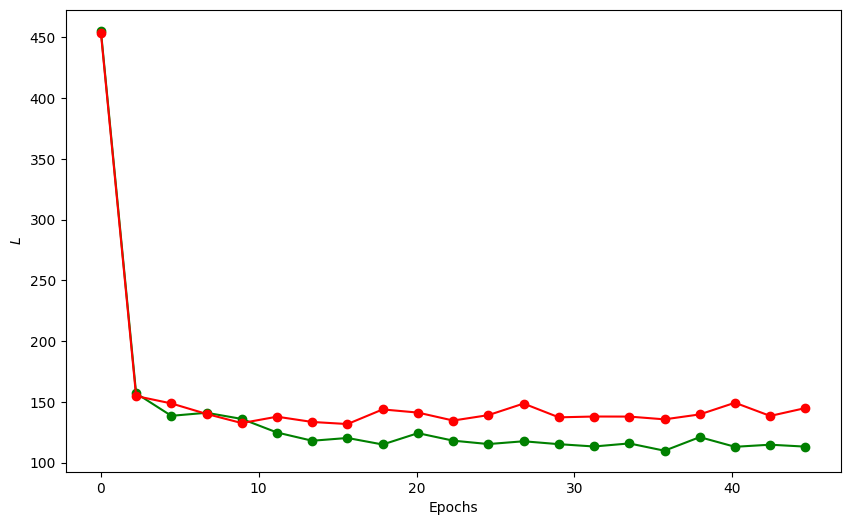

In [19]:
plot_training_history(history_3,
                      mini_batch_size,
                      seq_length,
                      len(train_data))